In [152]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import plotly.express as ply

In [153]:
a = np.array([[306, -506, 1.48e+03, 0, 0, -132],
 [-166, -12.6, 1.22e+03, 0, 0, -132]])
a

array([[ 306. , -506. , 1480. ,    0. ,    0. , -132. ],
       [-166. ,  -12.6, 1220. ,    0. ,    0. , -132. ]])

In [154]:
def line(a = np.array([0, 0, 0]), b = np.array([0, 0, 1])) :
    o = np.array([0, 0, 0])
    t = np.linspace(0, 1, 100)
    c = b - o
    x = a[0] + c[0]*t
    y = a[1] + c[1]*t
    z = a[2] + c[2]*t
    return x, y, z

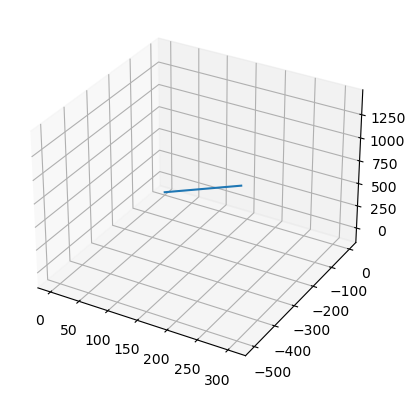

In [155]:
x = a[0][0::3]
y = a[0][1::3]
z = a[0][2::3]
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot(xs=x, ys=y, zs=z)

In [156]:
from read_out import ExtractFromRootFile

In [157]:
ef = ExtractFromRootFile()


In [158]:
edep = ef.extract("/ceph/kschmidt/beamdump/NN_Track_Reco/DiPhoton_CommonVertex_2023-05-26/", file="Diphoton5_CommonVertex_1000-2000MeV.root", keys=[])

Complete path to the files:
"/ceph/kschmidt/beamdump/NN_Track_Reco/DiPhoton_CommonVertex_2023-05-26/"
All keys: 
 ['fHits.fUniqueID', 'fHits.fBits', 'fHits.layerType', 'fHits.layerID', 'fHits.cellID', 'fHits.sourceParticleID', 'fHits.E', 'fHits.x', 'fHits.y', 'fHits.z']
Extract file:
"Diphoton5_CommonVertex_1000-2000MeV.root"


In [159]:
import awkward as ak
import uproot
import numpy as np

In [180]:
class TrainData_TrackReco :
    def extract_to_array(self, filename, key) :
        with uproot.open(filename) as data :
            return data[key].array(library="ak")
        
    def convertFromSourceFile(self, filename):
        # Training Data
        prefix = "Events;1/Output/fHits/fHits."
        keys = ["layerType", "x", "y", "z", "E"]
        d, arr = {}, []
        for _, keys in enumerate(keys) :
            d[keys] = self.extract_to_array(filename=filename, key=prefix+keys)
            d[keys] = d[keys][d["layerType"] > 0]
            arr.append(d[keys][..., np.newaxis])
        feature_array = ak.concatenate(arr, axis=-1)
        offsets = np.cumsum(np.array(np.append(0, np.array(ak.to_list(ak.num(feature_array, axis=1))))))
        
        print("Offsets", offsets)
        print("Feature array before removing empty arrays", np.shape(ak.flatten(feature_array, axis=1)))

        # Truth datas
        prefix = "Events;1/Output/fParticles/fParticles."
        keys = ["mcPx", "mcPy", "mcPz", "decayX", "decayY", "decayZ"]
        d, arr = {}, []
        for _, keys in enumerate(keys) :
            d[keys] = self.extract_to_array(filename=filename, key=prefix+keys)
            arr.append(d[keys][..., np.newaxis])
        truth_array = ak.concatenate(arr, axis=-1)
#            truth_array = ak.flatten(ak.unflatten(ak.flatten(truth_array, axis=-1), counts=2, axis=-1), axis=0)
        truth_array = ak.flatten(truth_array, axis=-1)
        
        feature_array, truth_array, offsets = self.remove_empty_events(feature_array, truth_array, offsets)

        feature_array = np.array(ak.to_list(ak.flatten(feature_array, axis=1)))
        feature_array = feature_array.astype(dtype='float32', order='C', casting="same_kind")
        truth_array = np.array(ak.to_list(truth_array)).astype(dtype='float32', order='C', casting="same_kind")

        print("Features", np.shape(feature_array))
        print("Truth", np.shape(truth_array))
        print("offsets", np.shape(offsets))

        return feature_array, truth_array, offsets

    def remove_empty_events(self, features, truth, offsets_cumulative) :
        keep_index = np.zeros(len(offsets_cumulative)-1, dtype='bool')
        discarded = []
        for i in range(1, len(offsets_cumulative)) :
            if offsets_cumulative[i-1] != offsets_cumulative[i] :
                keep_index[i-1] = True
            else :
                np.append(discarded, i)
        return features[keep_index], truth[keep_index], offsets_cumulative

In [181]:
td = TrainData_TrackReco()
f,t, o = td.convertFromSourceFile("/ceph/kschmidt/beamdump/NN_Track_Reco/DiPhoton_CommonVertex_2023-05-26/Diphoton5_CommonVertex_1000-2000MeV.root")

Offsets [     0     40    115 ... 458343 458383 458423]
Feature array before removing empty arrays [458423, 5]
Features (458423, 5)
Truth (9861, 12)
offsets (9862,)


In [182]:
f[100]

array([  2.     ,  41.     ,  82.     , 250.33   ,  53.14864],
      dtype=float32)

In [163]:
o

array([     0,     40,    115, ..., 458343, 458383, 458423])

In [164]:
t[1]

array([   10.233198,   111.21631 ,  1897.6743  ,     0.      ,
           0.      , -1013.47375 ,  -130.78113 ,   -67.37828 ,
        1398.6713  ,     0.      ,     0.      , -1013.47375 ],
      dtype=float32)